# Analyzing and Predicting Facebook Post Lifetime Engaged Users

### Project Structure
1. Project Question and Dataset Description
2. Loading and viewing dataset
3. Pre-processing
4. Exploratory Data Analysis
5. Modeling 
    - Outlier removal and re-shaping dataframe
    - Linear Regression
    - Random Forest Regression
6. Take-aways
7. References

Data comes via the UCI dataset: https://archive.ics.uci.edu/ml/datasets/Facebook+metrics

## 1. Question: Which posts reach the most amount of users, and can we predict how many users a post wil reach?
#### Assumptions:
- higher Facebook engagement leads to more downloads and overall engagement with the app
- There have been no changes in FB's feed algorithm since the data was posted (it has been already)
- data is generalizable to population (data is from cosmetics page over a year)

#### Dataset info
##### Variables
- Page total likes: how many likes the page had when post went live
- Type: what kind of post (video, link, status, photo)
- Category: not sure, 3 levels
- Post Month
- Post Weekday
- Post Hour
- Paid
- like
- share
- comment
- total interactions (comments + likes + shares)
- Lifetime Post metrics (recorded after posting, EDA only)
- <b/>Lifetime Engaged Users  (this will be the modeling variable) </b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 2. Loading and Viewing the data

In [2]:
df = pd.read_csv("dataset_Facebook.csv",delimiter=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 19 columns):
Page total likes                                                       500 non-null int64
Type                                                                   500 non-null object
Category                                                               500 non-null int64
Post Month                                                             500 non-null int64
Post Weekday                                                           500 non-null int64
Post Hour                                                              500 non-null int64
Paid                                                                   499 non-null float64
Lifetime Post Total Reach                                              500 non-null int64
Lifetime Post Total Impressions                                        500 non-null int64
Lifetime Engaged Users                                                 500 non-nul

In [4]:
df.head(3)

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,109,159,3078,1640,119,4,79.0,17.0,100
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,1361,1674,11710,6112,1108,5,130.0,29.0,164
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,113,154,2812,1503,132,0,66.0,14.0,80


Because columns 7 to 15 ("Lifetime post total impressions","Lifetime Engaged users", etc.) are recorded after posting, they will not be used for modeling. However, they can give useful information about post reach, and we will be looking at them in EDA.

In [766]:
#df.drop(df.columns[7:15],
#        axis=1,inplace=True)

We need to fill the values that are blank with 0:

Goal: predict Total Interactions based on features

I have excluded comment, like, and share and instead focused on Total Interactions, which is what we will be modeling for. 

An outlier is easily visible for total interactions, at around 6000. 

### Pre-processing

In [5]:
df['Paid'].value_counts()
df['like'].fillna(0,inplace=True)
df['share'].fillna(0,inplace=True)
df['Paid'].fillna(0,inplace=True)

In [6]:
#df.drop(df.columns[1],axis=1,inplace = True)

## EDA

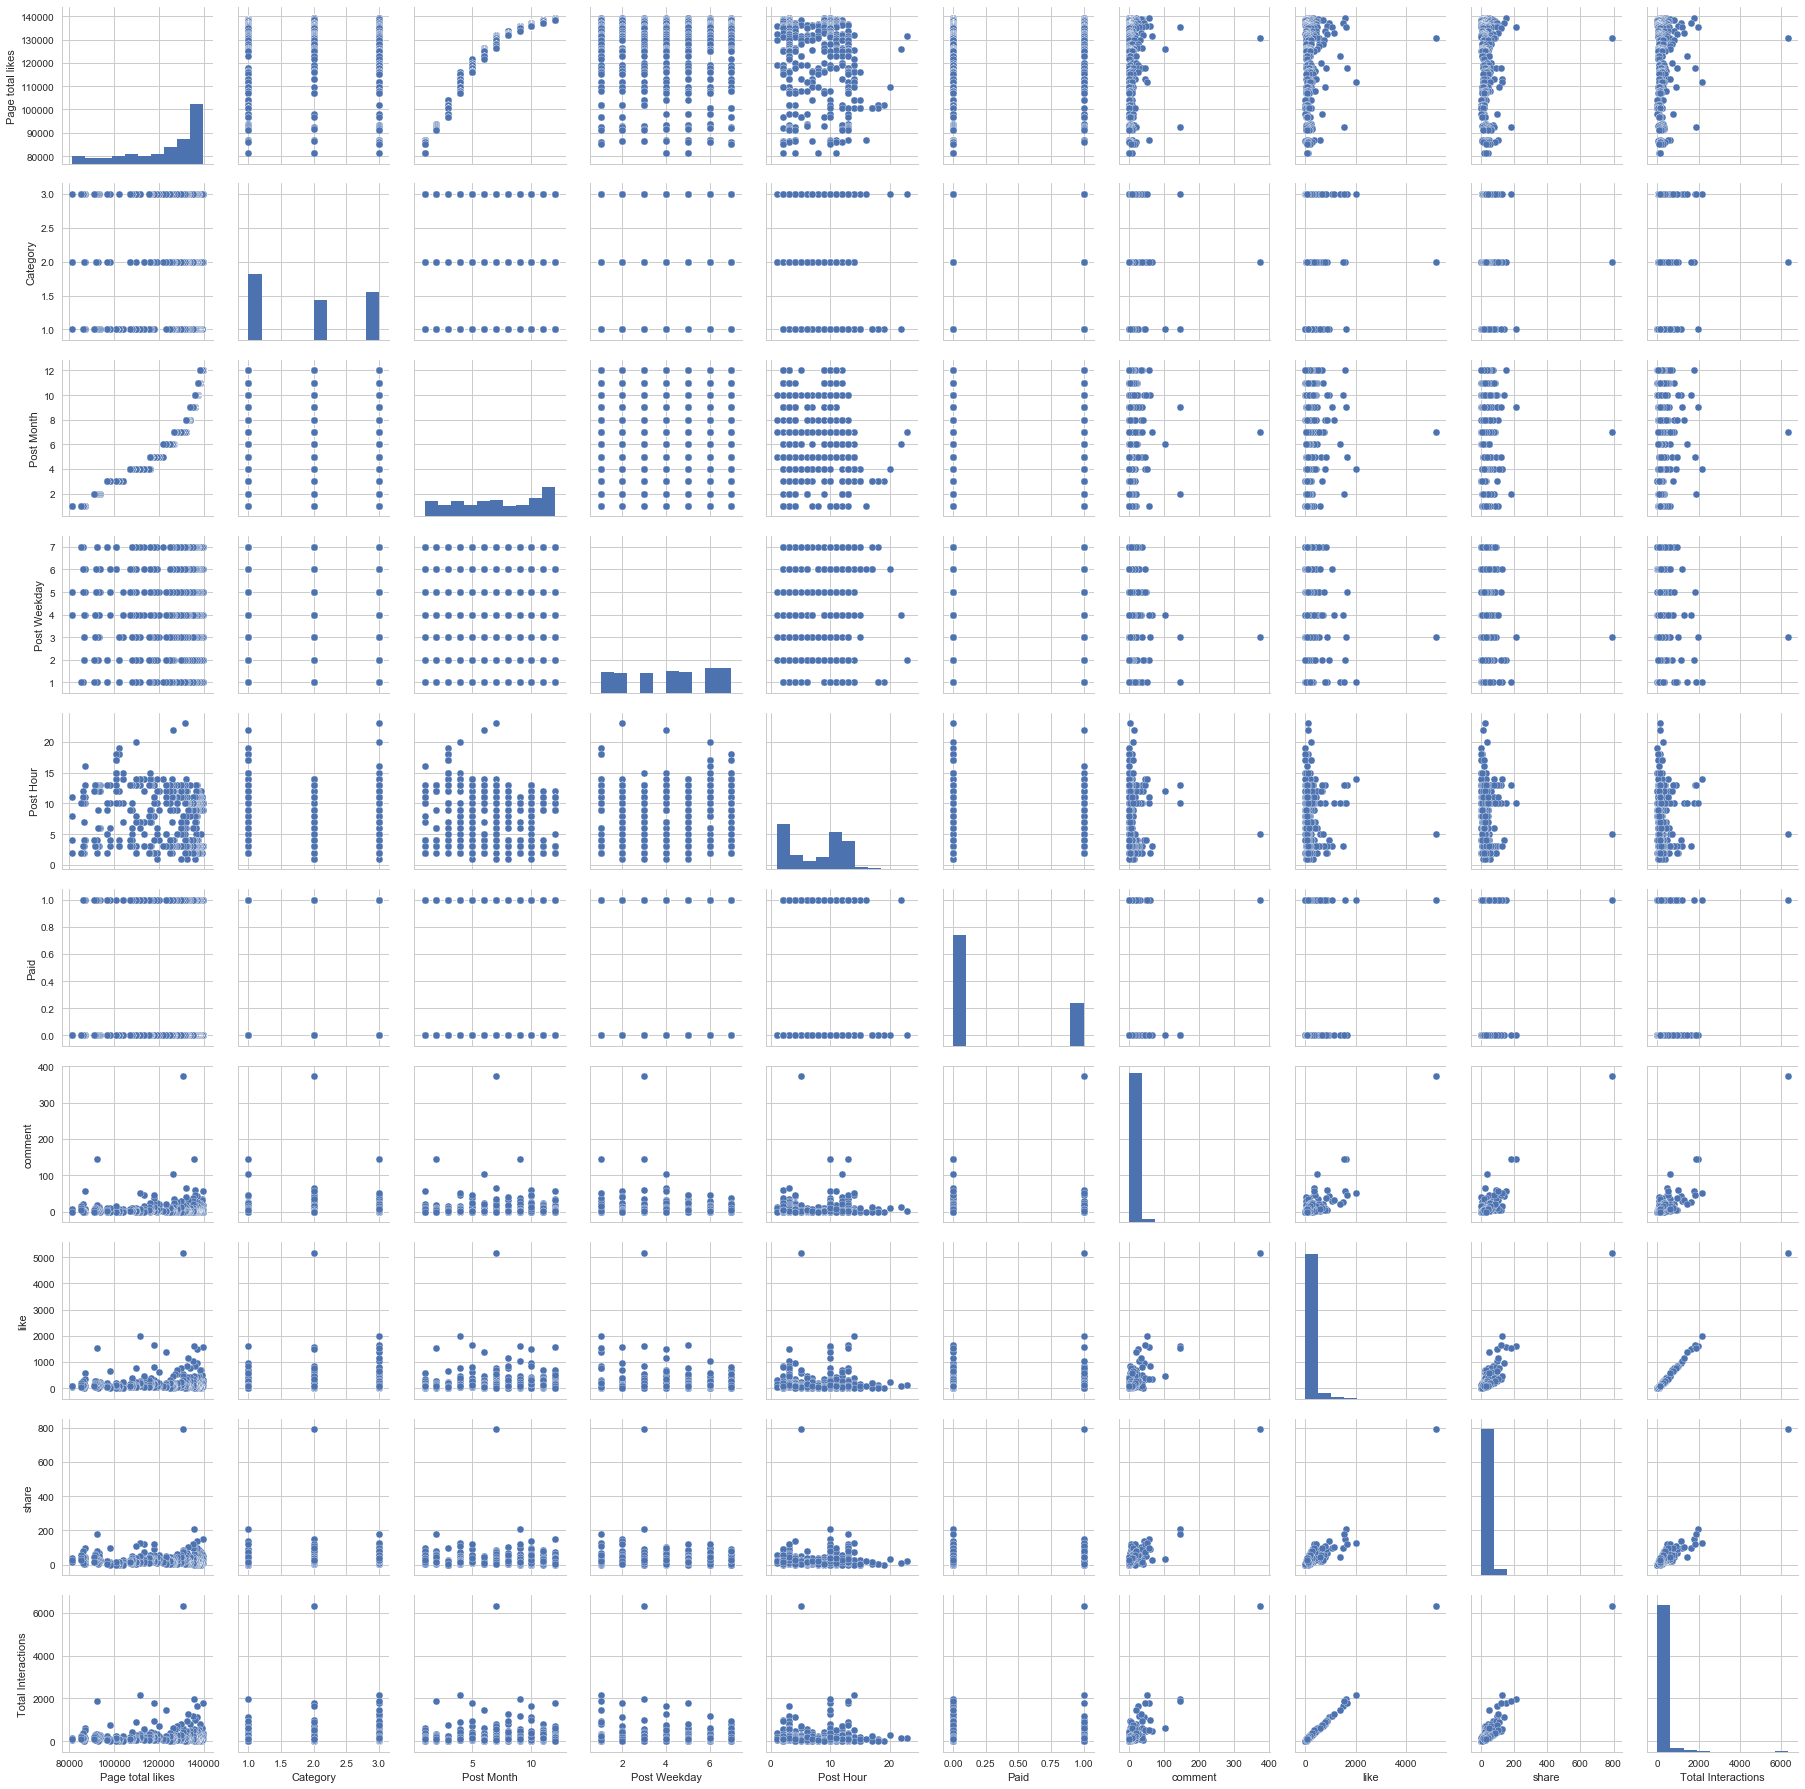

In [831]:
df['Type'] = df['Type'].apply(lambda x: str(x))
plotdf = df.drop(df.columns[7:15],axis =1)
sns.pairplot(data=plotdf)

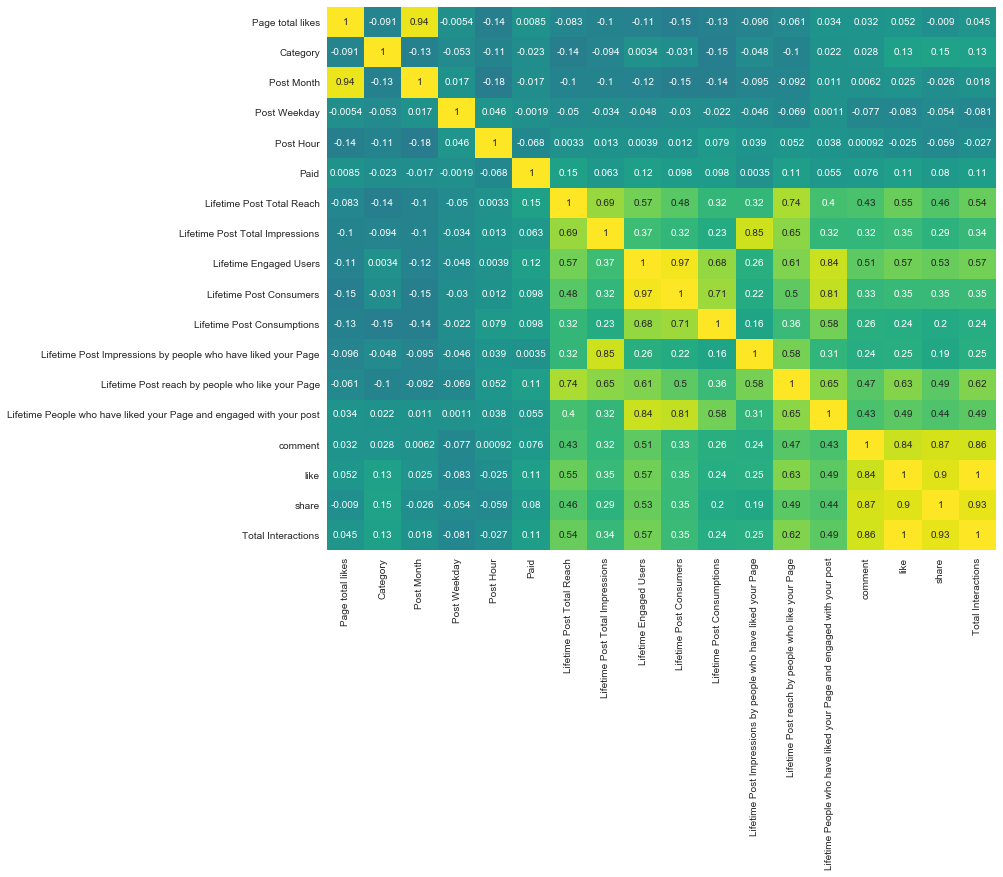

In [7]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),cmap='viridis',annot=True,cbar=False)

The lifetime metrics all appear to have high correlation wiith the engagement metrics- likes, comments, shares, total interactions (a sum of the 3 prior features). This suggests a regression model predicting total engaged users might have suitable performance.

### EDA of Lifetime Metrics

(0, 4000)

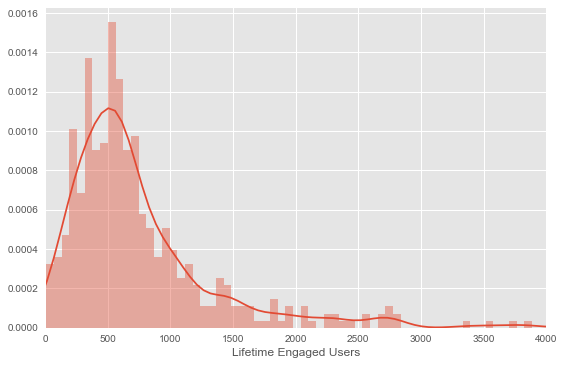

In [724]:
sns.distplot(df['Lifetime Engaged Users'],bins=100)
plt.xlim(0,4000)

The majority of posts engaged between 0 and 2000 users, with a dramatic left skew. The max was 12000 users engaged. 

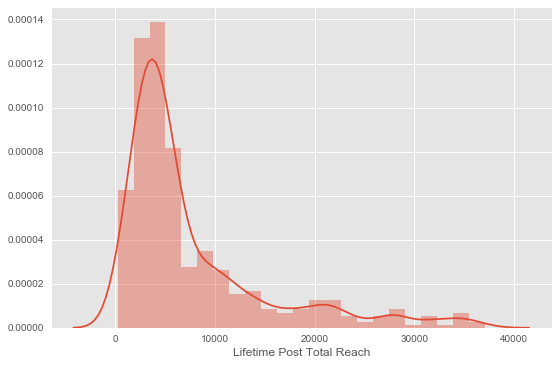

In [725]:
sns.distplot(df['Lifetime Post Total Reach'])
#plt.xlim(0,15000)

The majority of posts reached between 0 and 8000 users, and similar to the engaged users, a dramatic left skew.

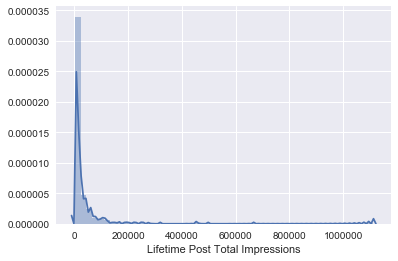

In [17]:
sns.distplot(df['Lifetime Post Total Impressions'],bins=50)
#plt.xlim(0,15000)

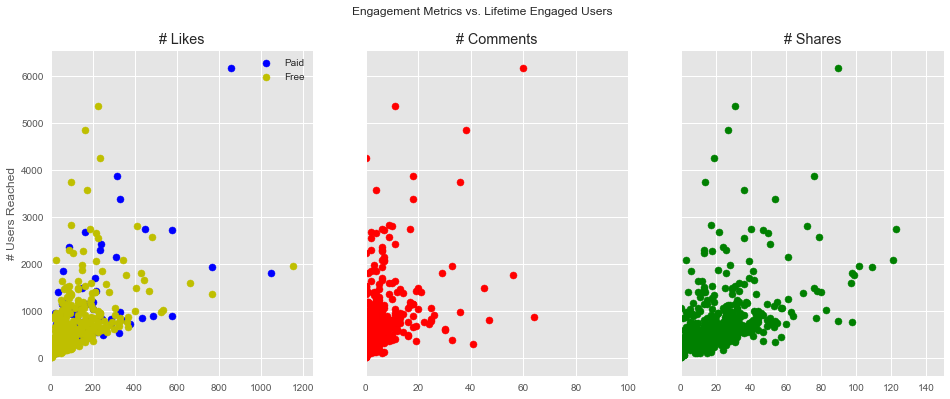

In [594]:
plt.style.use('ggplot')

fig, ax = plt.subplots(ncols=3,nrows=1,sharey=True,figsize=(16,6))
paid = df[df['Paid']==1]
free = df[df['Paid']==0]


ax[0].scatter(paid['like'],paid['Lifetime Engaged Users'],color='b')
ax[0].scatter(free['like'],free['Lifetime Engaged Users'],color='y')
ax[0].set_title('# Likes')
ax[0].set_xlim(0,1250)
ax[0].legend(labels=['Paid','Free'])

ax[1].scatter(df['comment'],df['Lifetime Engaged Users'],color='r')
ax[1].set_title('# Comments')
ax[1].set_xlim(0,100)

ax[2].scatter(df['share'],df['Lifetime Engaged Users'],color='g')
ax[2].set_title('# Shares')
ax[2].set_xlim(0,150)

ax[0].set_ylabel("# Users Reached")

fig.suptitle('Engagement Metrics vs. Lifetime Engaged Users',fontsize=12)

#fig.tight_layout()
#fig.canvas.set_window_title('Engagement Metrics vs. Lifetime Reach') 
#set_title('')

We see positive relationships most explicitly between Lifetime Engaged Users and likes/shares, and less so for comments.

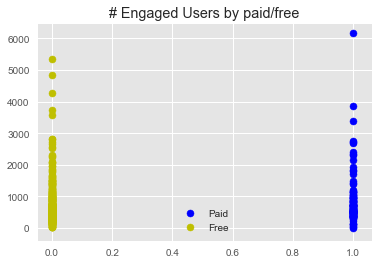

In [597]:
fig, ax = plt.subplots()
ax.scatter(paid['Paid'],paid['Lifetime Engaged Users'],color='b')
ax.scatter(free['Paid'],free['Lifetime Engaged Users'],color='y')
ax.set_title('# Engaged Users by paid/free')
ax.legend(labels=['Paid','Free'])

Not much difference between paid/free post performance on Lifetime Engaged Users.

In [599]:
df.columns

Index([u'Page total likes', u'Type', u'Category', u'Post Month',
       u'Post Weekday', u'Post Hour', u'Paid', u'Lifetime Post Total Reach',
       u'Lifetime Post Total Impressions', u'Lifetime Engaged Users',
       u'Lifetime Post Consumers', u'Lifetime Post Consumptions',
       u'Lifetime Post Impressions by people who have liked your Page',
       u'Lifetime Post reach by people who like your Page',
       u'Lifetime People who have liked your Page and engaged with your post',
       u'comment', u'like', u'share', u'Total Interactions', u'Weekday', u'Fr',
       u'Mo', u'Sa', u'Su', u'Th', u'Tu', u'We', u'hr__1', u'hr__2', u'hr__3',
       u'hr__4', u'hr__5', u'hr__6', u'hr__7', u'hr__8', u'hr__9', u'hr__10',
       u'hr__11', u'hr__12', u'hr__13', u'hr__14', u'hr__15', u'hr__16',
       u'hr__17', u'hr__18', u'hr__19', u'hr__20', u'hr__22', u'hr__23',
       u'Mo_1', u'Mo_2', u'Mo_3', u'Mo_4', u'Mo_5', u'Mo_6', u'Mo_7', u'Mo_8',
       u'Mo_9', u'Mo_10', u'Mo_11', u'Mo_12', u'V

(0, 3000)

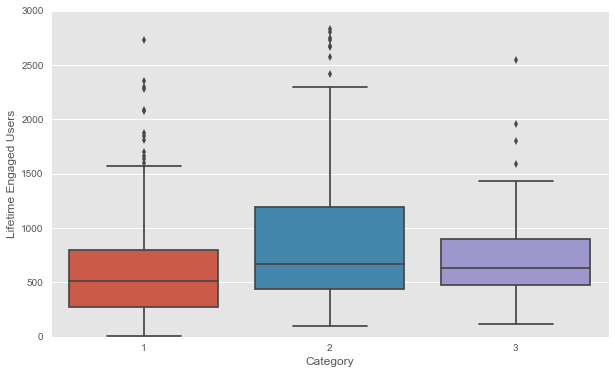

In [615]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['Category'],y=df['Lifetime Engaged Users'])
plt.ylim(0,3000)

Category 2 posts on average had engaged a higher number of users.

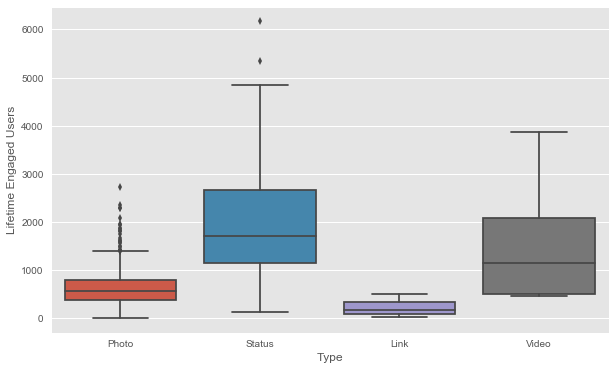

In [619]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['Type'],y=df['Lifetime Engaged Users'])
#plt.ylim(0,3000)

Status and Video posts, followed by photo posts, engaged the most users.

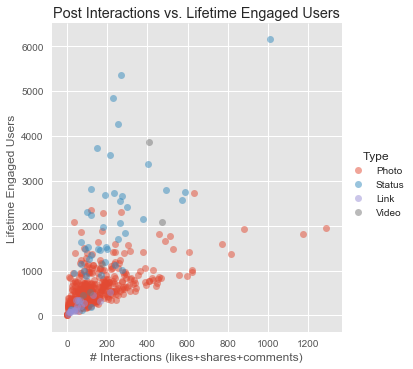

In [691]:
plt.style.use('ggplot')
sns.lmplot(x='Total Interactions',y='Lifetime Engaged Users',
           hue='Type',data=df,fit_reg=False,scatter_kws= {'alpha':0.5})
plt.xlabel("# Interactions (likes+shares+comments)")
plt.title('Post Interactions vs. Lifetime Engaged Users')

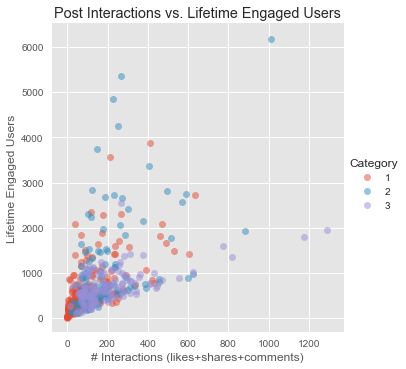

In [692]:
plt.style.use('ggplot')
sns.lmplot(x='Total Interactions',y='Lifetime Engaged Users',
           hue='Category',data=df,fit_reg=False,scatter_kws= {'alpha':0.5})
plt.xlabel("# Interactions (likes+shares+comments)")
plt.title('Post Interactions vs. Lifetime Engaged Users')

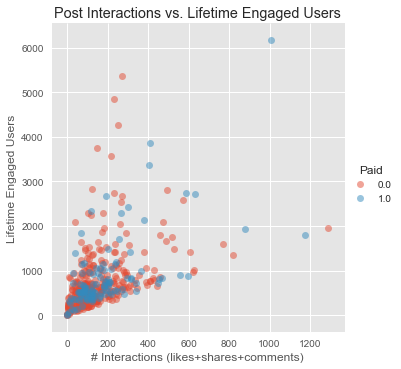

In [693]:
plt.style.use('ggplot')
sns.lmplot(x='Total Interactions',y='Lifetime Engaged Users',
           hue='Paid',data=df,fit_reg=False,scatter_kws= {'alpha':0.5})
plt.xlabel("# Interactions (likes+shares+comments)")
plt.title('Post Interactions vs. Lifetime Engaged Users')

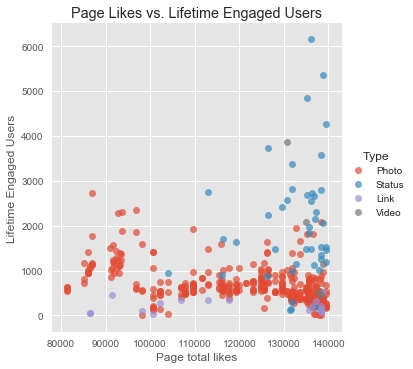

In [696]:
plt.style.use('ggplot')
sns.lmplot(x='Page total likes',y='Lifetime Engaged Users',
           hue='Type',data=df,fit_reg=False,scatter_kws= {'alpha':0.7})
#plt.xlabel("# Interactions (likes+shares+comments)")
plt.title('Page Likes vs. Lifetime Engaged Users')

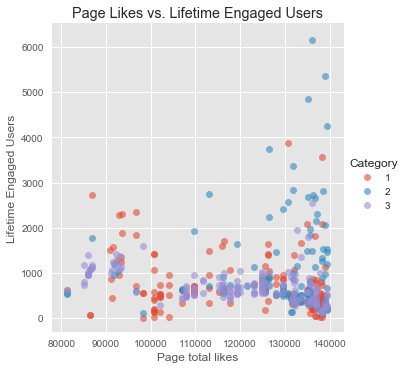

In [697]:
plt.style.use('ggplot')
sns.lmplot(x='Page total likes',y='Lifetime Engaged Users',
           hue='Category',data=df,fit_reg=False,scatter_kws= {'alpha':0.6})
#plt.xlabel("# Interactions (likes+shares+comments)")
plt.title('Page Likes vs. Lifetime Engaged Users')

(0, 3000)

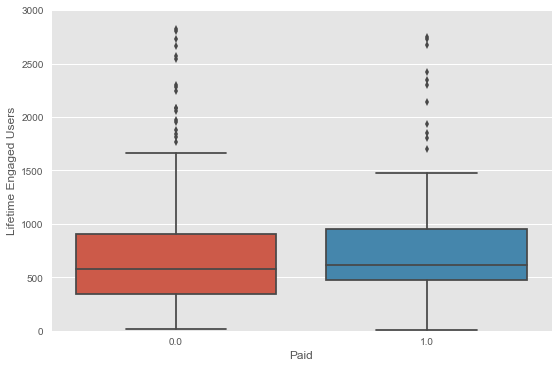

In [721]:
plt.style.use('ggplot')
sns.boxplot(x=df['Paid'],y=df['Lifetime Engaged Users'])
plt.ylim(0,3000)

No real difference in lifetime engaged users from paid posts or not, though Paid posts do have a slightly higher median.

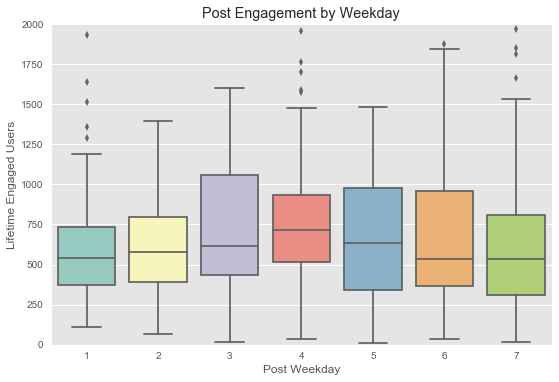

In [720]:
plt.style.use('ggplot')
sns.boxplot(x=df['Post Weekday'],y=df['Lifetime Engaged Users'],palette='Set3')
plt.ylim(0,2000)
plt.title("Post Engagement by Weekday")
#plt.xticks(labs=['Su','M','Tu','W','Th','F','Sa'])

# Modeling: Can we predict how many users a post will engage?

The goal is to get an estimate of how many users a post engaged over its lifetime, by using its categorical featues (when it was posted, what type of post) and engagement metrics (likes, shares, comments). 

This could be useful when measuring post performance.

In [38]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest

### Removing Outliers and Binarizing Categorical Variables

To remove the decent amount of outliers, I will remove any data points (rows) that are above the 90th percentile.

After, I will span the categorical columns out into binary features. To avoid multicolinearity, I will be taking n-1 columns for each feature.

#### Removing Outliers

In [9]:
#outlierCut = np.percentile(df['Lifetime Post Total Reach'],90)
outlierCut = np.percentile(df['Lifetime Post Total Reach'],90)
outlierCut

37116.800000000003

In [10]:
df = df[df['Lifetime Post Total Reach']<outlierCut]

The function below will translate the weekdays to their labels, rather than 1-7.

In [11]:
def Weekday(x):
    if x == 1:
        return 'Su'
    elif x== 2:
        return 'Mo'
    elif x == 3:
        return 'Tu'
    elif x == 4:
        return 'We'
    elif x == 5:
        return 'Th'
    elif x ==6:
        return 'Fr'
    elif x == 7:
        return "Sa"

df['Weekday'] = df['Post Weekday'].apply(lambda x: Weekday(x))

#### Spanning out categorical columns

In [12]:
dayDf = pd.get_dummies(df['Weekday'])

In [13]:
df = pd.concat([df,dayDf],axis=1)

In [14]:
hours = list(range(0,18))
#hours
for i in hours:
    hours[i] = str(hours[i])
    hours[i]='hr_'+ hours[i]
    #print str(hours[i])

In [15]:
hourDf = pd.get_dummies(df['Post Hour'],prefix='hr_')
df = pd.concat([df,hourDf],axis=1)
monthDf = pd.get_dummies(df['Post Month'],prefix='Mo')
df = pd.concat([df,monthDf],axis=1)
df['Video'] = pd.get_dummies(df['Type'])['Video']
df['Status'] = pd.get_dummies(df['Type'])['Status']
df['Photo'] = pd.get_dummies(df['Type'])['Photo']
df['Cat_1'] = pd.get_dummies(df['Category'])[1]
df['Cat_2'] = pd.get_dummies(df['Category'])[2]
#To avoid multicollinearity with the post types I am not including Links.

In [16]:
df.head()

,Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,...,Mo_8,Mo_9,Mo_10,Mo_11,Mo_12,Video,Status,Photo,Cat_1,Cat_2
0,139441,Photo,2,12,4,3,0.0,2752,5091,178,...,0,0,0,0,1,0,0,1,0,1
1,139441,Status,2,12,3,10,0.0,10460,19057,1457,...,0,0,0,0,1,0,1,0,0,1
2,139441,Photo,3,12,3,3,0.0,2413,4373,177,...,0,0,0,0,1,0,0,1,0,0
4,139441,Photo,2,12,2,3,0.0,7244,13594,671,...,0,0,0,0,1,0,0,1,0,1
5,139441,Status,2,12,1,9,0.0,10472,20849,1191,...,0,0,0,0,1,0,1,0,0,1


### More Pre-processing

In [89]:
scaler = MinMaxScaler(feature_range=(0,1))
df['Scaled_Lifetime Post Total Reach'] = scaler.fit_transform(df['Lifetime Post Total Reach']) 
df['scaled_Page total likes'] = scaler.fit_transform(df['Page total likes']) 


//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

### Train Test Split

In [90]:
#
x = df[['scaled_Page total likes','Paid','Video','Status','Photo','Total Interactions',#"like",'comment','share',
    'Cat_1','Cat_2','Mo','Tu','Sa',"We",'Th','Fr',
       'hr__17','hr__1','hr__2','hr__3','hr__4','hr__5', 'hr__6','hr__7','hr__8',
        'hr__9','hr__10','hr__11','hr__12','hr__13','hr__14','hr__15','hr__16','Mo_1',
       'Mo_2','Mo_12','Mo_4','Mo_5','Mo_6','Mo_7','Mo_8','Mo_9','Mo_11','Mo_10']]
y = df['Lifetime Engaged Users']
#y = df['Scaled_Lifetime Post Total Reach']

#### Feature Selection 

In [91]:
# Select 20 best features using k-best
k_best = SelectKBest(k=20)
k_best.fit(x,y)

SelectKBest(k=20, score_func=<function f_classif at 0x10e8ceb18>)

There are many features here, so we will need a bit of feature selection. I will take the 20 best features here, and then in the second iteration we will take the top 4. 

In [92]:
# Getting the indices for the top columns
k_best.get_support(indices=True)

array([ 0,  3,  4,  5,  6,  7,  9, 10, 14, 15, 16, 17, 20, 24, 27, 32, 33,
       35, 38, 41])

In [93]:
# filtering the reduced columns
ogCols = x.columns
new_cols = [ogCols[i] for i in k_best.get_support(indices=True)]
new_cols

['scaled_Page total likes',
 'Status',
 'Photo',
 'Total Interactions',
 'Cat_1',
 'Cat_2',
 'Tu',
 'Sa',
 'hr__17',
 'hr__1',
 'hr__2',
 'hr__3',
 'hr__6',
 'hr__10',
 'hr__13',
 'Mo_2',
 'Mo_12',
 'Mo_5',
 'Mo_8',
 'Mo_10']

With our reduced 20 columns, we can now move on to the train/test split. 

The train test split will be with a test size of 0.2, and a random state of 50. With 500 samples a 20% split should not lead to overfitting.

In [94]:
x = df[new_cols]
#x = df[topVars]

x_train,x_test,y_train, y_test = train_test_split(x,
                                                  y, test_size=0.2,
                                                  random_state=50)

In [95]:
y_test.count()

90

In [96]:
x_test.columns

Index([u'scaled_Page total likes', u'Status', u'Photo', u'Total Interactions',
       u'Cat_1', u'Cat_2', u'Tu', u'Sa', u'hr__17', u'hr__1', u'hr__2',
       u'hr__3', u'hr__6', u'hr__10', u'hr__13', u'Mo_2', u'Mo_12', u'Mo_5',
       u'Mo_8', u'Mo_10'],
      dtype='object')

## Linear and Lasso Regression

I will use both a Linear Regression model and a Lasso Regression model. The former to serve as a benchmark, and the latter to reduce dimensionality when I use the Random Forest model, which will help overfitting.

In [97]:
reg = linear_model.LinearRegression(normalize=True)
lasso = linear_model.Lasso(normalize=True)
reg.fit(x_train,y_train)
lasso.fit(x_train,y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

The Lasso model functions like a Linear Regression model, but places a weight of 0 for features that do not contain useful information.
See below:

In [98]:
lasso.coef_

array([ -359.85333435,  1318.56101438,    -0.        ,     2.01372891,
          82.57171658,     0.        ,   100.34526015,    22.88055661,
           0.        ,    -0.        ,    -0.        ,   -85.50492943,
          -0.        ,     0.        ,     0.        ,   345.48600344,
           0.        ,   -14.08126393,   -26.07133936,    -0.        ])

##### Extract features from lasso:

In [99]:
lassV = pd.DataFrame()
lassV['Variable'] = list(x_train.columns)
lassV['Importance'] = lasso.coef_
lassoVars = lassV[lassV['Importance'] > 0]
lassoVars = list(lassoVars['Variable'])

##### Model Validation

In [100]:
def RegScorePlot(model,x_train= None,y_train=None, x_test=None,y_test=None,saveFig=False): 
    from sklearn.metrics import r2_score
    from scipy.stats import spearmanr, pearsonr
    
    # getting predictions from test and train and scoring them
    predicted_test = model.predict(x_test)
    test_score = r2_score(y_test, predicted_test)
    spearmanTest = spearmanr(y_test, predicted_test)
    pearsonTest = pearsonr(y_test, predicted_test)
    
    # getting training scoring
    predicted_train = model.predict(x_train)
    train_score = r2_score(y_train, predicted_train)
    spearmanTrain = spearmanr(y_train, predicted_train)
    pearsonTrain = pearsonr(y_train, predicted_train)
    
    # printing results 
    print('Train data R-2 score: {}').format(train_score)
    print('Train data Spearman correlation: {}').format(spearmanTrain[0])
    print('Train data Pearson correlation: {}').format(pearsonTrain[0])
    print(' ')
    print('Test data R-2 score: {}').format(test_score)
    print('Test data Spearman correlation: {}').format(spearmanTest[0])
    print('Test data Pearson correlation: {}').format(pearsonTest[0])
    
    #creating dataframe to plot
    RFperf = pd.DataFrame()
    RFperf['Score'] = [round(train_score,3),round(test_score,3),
                           spearmanTrain[0],spearmanTest[0],
                          pearsonTrain[0],pearsonTest[0]]
    RFperf['Step'] = ['train','test','train','test','train','test']
    RFperf['metric'] = ['r2','r2','Spearman','Spearman','Pearson',"Pearson"]

    #plotting results
    sns.pointplot(y=RFperf['Score'],x=RFperf['Step'],hue=RFperf['metric'])
    plt.ylim([-.1,1])
    plt.title('Model Scores')
    plt.show()
    
    #can save fig if you want
    if saveFig:
        plt.savefig('{}Scores.png'.format(model),bbox_inches='tight')

    return RFperf
    #return predicted_train,predicted_test, test_score, train_score,spearmanTrain, \
#spearmanTest,pearsonTrain,pearsonTest
    


Train data R-2 score: 0.571307324905
Train data Spearman correlation: 0.738646786281
Train data Pearson correlation: 0.757638652737
 
Test data R-2 score: 0.670564775879
Test data Spearman correlation: 0.805791876615
Test data Pearson correlation: 0.821101008523


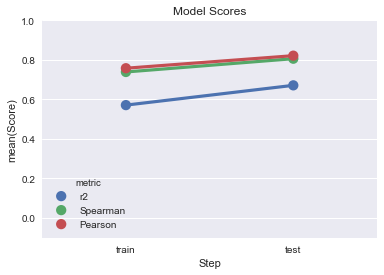

In [101]:
lassoPerf = RegScorePlot(lasso,x_test=x_test,x_train=x_train,y_test=y_test,y_train=y_train)

In [102]:
lassoPerf

,Score,Step,metric
0,0.571000,train,r2
1,0.671000,test,r2
2,0.738647,train,Spearman
3,0.805792,test,Spearman
4,0.757639,train,Pearson
5,0.821101,test,Pearson


Train data R-2 score: 0.581880456777
Train data Spearman correlation: 0.717378692934
Train data Pearson correlation: 0.762810891884
 
Test data R-2 score: 0.680930048571
Test data Spearman correlation: 0.769135787753
Test data Pearson correlation: 0.825790546119


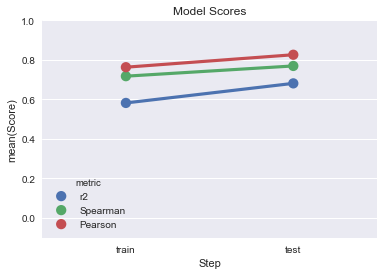

In [103]:
regPerf = RegScorePlot(reg,x_test=x_test,x_train=x_train,y_test=y_test,y_train=y_train)

#### Assumptions

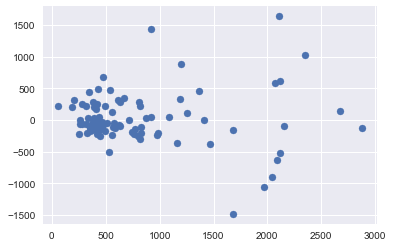

In [104]:
pred = reg.predict(x_test)
error = y_test - pred

plt.scatter(pred, error)

The error increases as the value of engaged users increases. Thus, this violates the one of the main assumptions of a linear regression model. 

##### Results

The linear regression model performed solid overall. 
- No overfitting: the R2 value rose .045 points from train to test
- Moderate predictive power: .64 R2 train, .68 in test

I had to tune the test set division to 10% of the total dataset, to get the highest R2 value.

#### Let's try a different approach- a Random Forest Regressor.

## Random Forest Regression

In [105]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

As the Linear Regression train/test split was tuned for, I will set the split back to my preliminary value of 0.3

In [106]:
len(new_cols)

20

#### Train-test split and model fitting

In [107]:
x = df[new_cols]

x_train,x_test,y_train, y_test = train_test_split(x,
                                                  y, test_size=0.3,
                                                  random_state=50)

For the Random Forest we will use a min samples split of 10, as to avoid overfitting.

In [108]:
#rf = AdaBoostRegressor(n_estimators=500)

rf = RandomForestRegressor(n_estimators=500,min_samples_split=15)
rf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=15, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

#### Model Validation

Train data R-2 score: 0.738645947783
Train data Spearman correlation: 0.911010262456
Train data Pearson correlation: 0.868688596933
 
Test data R-2 score: 0.720672934047
Test data Spearman correlation: 0.855503960791
Test data Pearson correlation: 0.85248407035


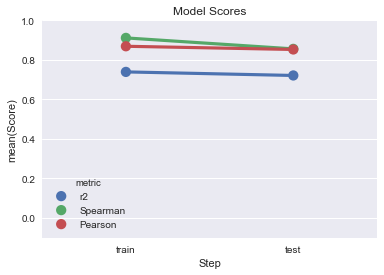

In [109]:
RfPerf = RegScorePlot(rf,x_test=x_test,x_train=x_train,y_test=y_test,y_train=y_train)

In [87]:
RfPerf

,Score,Step,metric
0,0.733000,train,r2
1,0.722000,test,r2
2,0.911371,train,Spearman
3,0.854455,test,Spearman
4,0.864652,train,Pearson
5,0.852673,test,Pearson


Best results came from 
- RF parameters:
    - 500 estimators
    - 15 min sample split 
- Train/test split of 0.3

We had solid performance in the test set, with:
    - .772 r^2
    - .919 Spearman Correlation

But the model showed some signs of overfitting when exposed to the test set:
    - reduction of .15 in the r^2
    - reduction of .10 in test Spearman Correlation
    
    
One reason that there could be overfitting is the large amount of features in the model. We can take the feature importance to get the top 15 features, then iterate through the Random Forest again, and see if overfitting persists.

#### Feature Importance - which are the most important features?

In [88]:
predicted_test = rf.predict(x_test)

fI = pd.DataFrame()
fI['Variable'] = list(x_train.columns)
fI['Importance'] = rf.feature_importances_
fI.sort_values(by='Importance',ascending=False)[0:15]

,Variable,Importance
3,Total Interactions,0.448305
1,Status,0.325577
0,Page total likes,0.135398
2,Photo,0.052067
15,Mo_2,0.012691
4,Cat_1,0.007428
10,hr__2,0.004178
7,Sa,0.003363
12,hr__6,0.002780
13,hr__10,0.001691


Month 2 (February) is something that may not be super helpful to predicting a post in the other 11 months, so for the next iteration of feature selection I will take the top 4 features above it:

In [63]:
topVars= list(fI.sort_values(by='Importance',ascending=False)[0:4]['Variable'])
topVars

['Total Interactions', 'Status', 'Cat_2', 'hr__7']

#### Can we improve the model by using only the top 4 features?

In [64]:
x = df[topVars]

x_train,x_test,y_train, y_test = train_test_split(x,
                                                  y, test_size=0.3,
                                                  random_state=50)

In [65]:
newRf = RandomForestRegressor(n_estimators=500,min_samples_split=15)
newRf.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=15, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Train data R-2 score: 0.586939378738
Train data Spearman correlation: 0.816084844627
Train data Pearson correlation: 0.774919783033
 
Test data R-2 score: 0.411055548756
Test data Spearman correlation: 0.565488849717
Test data Pearson correlation: 0.647945056308


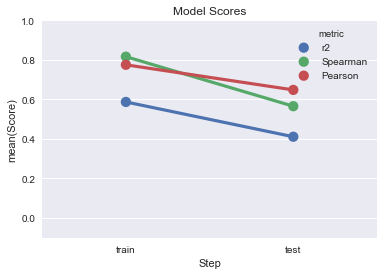

In [67]:
newRfPerf = RegScorePlot(newRf,x_test=x_test,x_train=x_train,y_test=y_test,y_train=y_train)

In [68]:
newRfPerf

,Score,Step,metric
0,0.587000,train,r2
1,0.411000,test,r2
2,0.816085,train,Spearman
3,0.565489,test,Spearman
4,0.774920,train,Pearson
5,0.647945,test,Pearson


The model performed no differently when taking the top 4 features by importance from the first model. It does not appear to have overfit (difference in train/test r^2 is now 0.014) and by all metrics is very consistent from training to test performance.

The simpler model (with the top 4 features only) had higher performance than the model with the k-best 20 features.

So, the final features are:

1) Total Interactions

2)	Status

3)	Page total likes

4)	Photo

### Modeling Conclusion

Iterating through a random forest using the most important variables led to some improvement, and the robust scoring metrics suggest that Lifetime Engaged Users can be modeled for to a reasonable degree.

The model was able to predict total engaged users by the number of total interactions a post had, if the post was a status or photo, and how many likes the page had at the time of posting.

A simple (4 feature) Random Forest performed better than a Lasso Regression model to a large degree, with a difference in test r^2 values of .05. However, both models demonstrated no signs of overfitting, with the test r^2 values all being close to or higher than the train r^2 value.

This model can provide value by giving posters an accurate estimate of how many users they engaged by post, particularly useful for optmizing for post scheduling, and measuring post performance. 

## References


(Moro et al., 2016) Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research, 69(9), 3341-3351. 
